In [31]:
!pip install pandas requests datasets tqdm transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [32]:
import os

# Create dataset directory
os.makedirs("datasets/security", exist_ok=True)
print("Created folder: datasets/security")


Created folder: datasets/security


In [33]:
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset("code_x_glue_cc_defect_detection")

# Check the available splits
print(dataset)

# Show a few samples
dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['id', 'func', 'target', 'project', 'commit_id'],
        num_rows: 21854
    })
    validation: Dataset({
        features: ['id', 'func', 'target', 'project', 'commit_id'],
        num_rows: 2732
    })
    test: Dataset({
        features: ['id', 'func', 'target', 'project', 'commit_id'],
        num_rows: 2732
    })
})


{'id': 0,
 'func': 'static av_cold int vdadec_init(AVCodecContext *avctx)\n\n{\n\n    VDADecoderContext *ctx = avctx->priv_data;\n\n    struct vda_context *vda_ctx = &ctx->vda_ctx;\n\n    OSStatus status;\n\n    int ret;\n\n\n\n    ctx->h264_initialized = 0;\n\n\n\n    /* init pix_fmts of codec */\n\n    if (!ff_h264_vda_decoder.pix_fmts) {\n\n        if (kCFCoreFoundationVersionNumber < kCFCoreFoundationVersionNumber10_7)\n\n            ff_h264_vda_decoder.pix_fmts = vda_pixfmts_prior_10_7;\n\n        else\n\n            ff_h264_vda_decoder.pix_fmts = vda_pixfmts;\n\n    }\n\n\n\n    /* init vda */\n\n    memset(vda_ctx, 0, sizeof(struct vda_context));\n\n    vda_ctx->width = avctx->width;\n\n    vda_ctx->height = avctx->height;\n\n    vda_ctx->format = \'avc1\';\n\n    vda_ctx->use_sync_decoding = 1;\n\n    vda_ctx->use_ref_buffer = 1;\n\n    ctx->pix_fmt = avctx->get_format(avctx, avctx->codec->pix_fmts);\n\n    switch (ctx->pix_fmt) {\n\n    case AV_PIX_FMT_UYVY422:\n\n        vda_

In [34]:
import pandas as pd

# Convert to pandas DataFrame
df_train = pd.DataFrame(dataset["train"])
df_valid = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

# Save
df_train.to_csv("datasets/security/train.csv", index=False)
df_valid.to_csv("datasets/security/valid.csv", index=False)
df_test.to_csv("datasets/security/test.csv", index=False)

print("Dataset saved as CSV files.")


Dataset saved as CSV files.


In [35]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         21854 non-null  int64 
 1   func       21854 non-null  object
 2   target     21854 non-null  bool  
 3   project    21854 non-null  object
 4   commit_id  21854 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 704.4+ KB
None
target
False    11836
True     10018
Name: count, dtype: int64


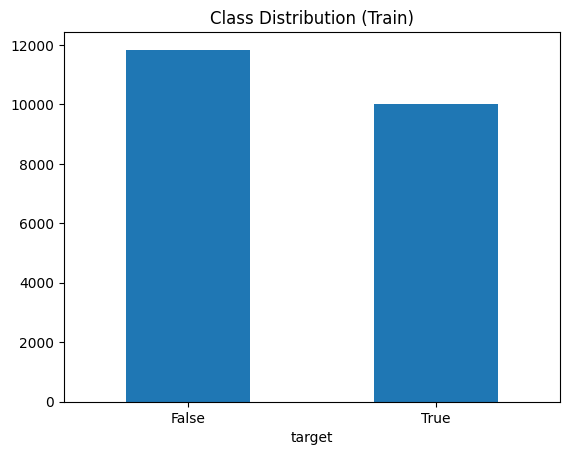

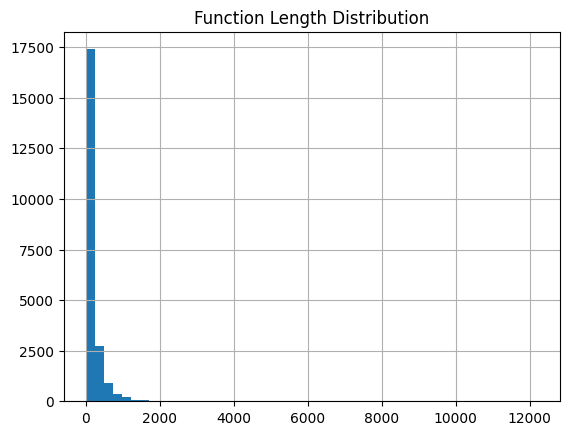

In [36]:
import matplotlib.pyplot as plt

# Basic stats
print(df_train.info())
print(df_train['target'].value_counts())

# Plot class distribution
df_train['target'].value_counts().plot(kind='bar', title='Class Distribution (Train)', rot=0)
plt.show()

# Optional: check function lengths
df_train['func_length'] = df_train['func'].apply(lambda x: len(x.split()))
df_train['func_length'].hist(bins=50)
plt.title("Function Length Distribution")
plt.show()

In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

def tokenize_code(row):
    return tokenizer(row["func"], truncation=True, max_length=512)

# Apply to a small sample first
df_sample = df_train.sample(10)
tokenized = df_sample.apply(tokenize_code, axis=1)

tokenized.head()

6345     [input_ids, attention_mask]
17171    [input_ids, attention_mask]
13585    [input_ids, attention_mask]
2971     [input_ids, attention_mask]
16127    [input_ids, attention_mask]
dtype: object

In [38]:
print("Tokenizing train set...")
df_train["tokens"] = df_train.apply(tokenize_code, axis=1)

print("Tokenizing validation set...")
df_valid["tokens"] = df_valid.apply(tokenize_code, axis=1)

print("Tokenizing test set...")
df_test["tokens"] = df_test.apply(tokenize_code, axis=1)

print("tokenization completed!")

Tokenizing train set...
Tokenizing validation set...
Tokenizing test set...
tokenization completed!


In [39]:
df_train["tokens"].iloc[0]

{'input_ids': [0, 42653, 6402, 1215, 33912, 6979, 748, 417, 1829, 438, 1215, 25153, 1640, 10612, 47436, 3204, 48522, 1009, 1469, 49575, 43, 50118, 50118, 45152, 50140, 1437, 1437, 1437, 468, 495, 2606, 3204, 15362, 48522, 1009, 49575, 5457, 6402, 49575, 46613, 25943, 1215, 23687, 131, 50140, 1437, 1437, 1437, 29916, 748, 6106, 1215, 46796, 1009, 705, 6106, 1215, 49575, 5457, 359, 49575, 46613, 705, 6106, 1215, 49575, 131, 50140, 1437, 1437, 1437, 8192, 47731, 2194, 131, 50140, 1437, 1437, 1437, 6979, 5494, 131, 50140, 50140, 1437, 1437, 1437, 740, 43820, 46613, 298, 29137, 1215, 49722, 5457, 321, 131, 50140, 50140, 1437, 1437, 1437, 48565, 45511, 181, 3181, 1215, 40523, 1872, 9, 45797, 48404, 50140, 1437, 1437, 1437, 114, 48209, 3145, 1215, 298, 29137, 1215, 705, 6106, 1215, 11127, 15362, 4, 642, 3181, 1215, 40523, 1872, 43, 25522, 50140, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 114, 36, 330, 347, 5268, 1688, 29991, 1258, 47322, 43623, 28696, 449, 347, 5268, 1688, 29991, 1258, 47322, 

In [40]:
import re
import random

def rename_variables(code):
    pattern = r"\b([a-zA-Z_][a-zA-Z_0-9]*)\b"
    reserved = {'for', 'while', 'if', 'else', 'return', 'int', 'float', 'void'}
    vars_found = list(set(re.findall(pattern, code)) - reserved)
    rename_map = {v: v + f"_{random.randint(100,999)}" for v in vars_found}
    for old, new in rename_map.items():
        code = re.sub(rf'\b{old}\b', new, code)
    return code

df_train['func_aug'] = df_train['func'].apply(rename_variables)

In [41]:
def insert_comment(code):
    lines = code.split('\n')
    if len(lines) > 2:
        idx = random.randint(1, len(lines) - 2)
        lines.insert(idx, "// TODO: review this logic")
    return '\n'.join(lines)

df_train['func_aug'] = df_train['func_aug'].apply(insert_comment)

In [42]:
def add_formatting_noise(code):
    code = code.replace("    ", "\t")
    return re.sub(r" {2,}", " ", code)

df_train['func_aug'] = df_train['func_aug'].apply(add_formatting_noise)

In [43]:
def insert_dead_code(code):
    dead_code = "\n    int dummy = 0; // dead code"
    brace_idx = code.find('{')
    if brace_idx != -1:
        return code[:brace_idx+1] + dead_code + code[brace_idx+1:]
    return code

df_train['func_aug'] = df_train['func_aug'].apply(insert_dead_code)

In [44]:
def extract_features(code):
    return {
        "func_length": len(code.split()),
        "num_loops": code.count("for") + code.count("while"),
        "has_eval": int("eval" in code or "exec" in code),
        "has_system": int("system" in code or "os." in code),
        "num_if": code.count("if"),
        "num_return": code.count("return"),
        "uses_pointer": int("*" in code),
        "uses_buffer": int("buffer" in code or "char" in code)
    }

features = df_train['func'].apply(extract_features).apply(pd.Series)
df_train = pd.concat([df_train, features], axis=1)

In [45]:
import ast

# Convert token dict into separate string columns
df_train["input_ids"] = df_train["tokens"].apply(lambda x: x["input_ids"])
df_train["attention_mask"] = df_train["tokens"].apply(lambda x: x["attention_mask"])

df_valid["input_ids"] = df_valid["tokens"].apply(lambda x: x["input_ids"])
df_valid["attention_mask"] = df_valid["tokens"].apply(lambda x: x["attention_mask"])

df_test["input_ids"] = df_test["tokens"].apply(lambda x: x["input_ids"])
df_test["attention_mask"] = df_test["tokens"].apply(lambda x: x["attention_mask"])

# Drop the original tokens dictionary column
df_train.drop(columns=["tokens"], inplace=True)
df_valid.drop(columns=["tokens"], inplace=True)
df_test.drop(columns=["tokens"], inplace=True)

# Save to CSV
df_train.to_csv("datasets/security/train_preprocessed.csv", index=False)
df_valid.to_csv("datasets/security/valid_preprocessed.csv", index=False)
df_test.to_csv("datasets/security/test_preprocessed.csv", index=False)

print("Preprocessed data saved as CSVs.")


Preprocessed data saved as CSVs.
